In [65]:
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sys

In [19]:
X = pickle.load(open('../Data/X_train_triplet', 'rb'))
y = pickle.load(open('../Data/y_test', 'rb'))

In [60]:
class siamese:

    # Create model
    def __init__(self):
        tf.reset_default_graph()
        self.x1 = tf.placeholder(tf.float32, [None, 978])
        self.x2 = tf.placeholder(tf.float32, [None, 978])
        self.x3 = tf.placeholder(tf.float32, [None, 978])

        with tf.variable_scope("siamese") as scope:
            self.o1 = self.network(self.x1)
            scope.reuse_variables()
            self.o2 = self.network(self.x2)
            scope.reuse_variables()
            self.o3 = self.network(self.x3)

        # Create loss
#         self.y_ = tf.placeholder(tf.float32, [None])
        self.loss = self.loss_with_step()

    def network(self, x):
        weights = []
        fc1 = self.fc_layer(x, 1024, "fc1")
        ac1 = tf.nn.relu(fc1)
        fc2 = self.fc_layer(ac1, 1024, "fc2")
        ac2 = tf.nn.relu(fc2)
        fc3 = self.fc_layer(ac2, 1, "fc3")
        return fc3

    def fc_layer(self, bottom, n_weight, name):
        assert len(bottom.get_shape()) == 2
        n_prev_weight = bottom.get_shape()[1]
        initer = tf.truncated_normal_initializer(stddev=0.01)
        W = tf.get_variable(name+'W', dtype=tf.float32, shape=[n_prev_weight, n_weight], initializer=initer)
        b = tf.get_variable(name+'b', dtype=tf.float32, initializer=tf.constant(0.01, shape=[n_weight], dtype=tf.float32))
        fc = tf.nn.bias_add(tf.matmul(bottom, W), b)
        return fc

    def loss_with_step(self):         # labels_ = !labels;
        eucd2 = tf.pow(tf.subtract(self.o1, self.o2), 2)
        eucd2 = tf.sqrt(tf.reduce_mean(eucd2, 0))
        eucd3 = tf.pow(tf.subtract(self.o1, self.o3), 2)
        eucd3 = tf.sqrt(tf.reduce_mean(eucd3, 0))
        return eucd2, eucd3

In [61]:
s = siamese()
optim_neg = tf.train.AdamOptimizer(0.05).minimize(s.loss[1])
optim_pos = tf.train.AdamOptimizer(0.05).minimize(-s.loss[0])

In [69]:
with tf.Session() as session:  
    tf.initialize_all_variables().run()
    print("Initialized")
    
    feed_dict={s.x1:X[0], s.x2:X[1], s.x3:X[2]}
    
    p_loss = []
    n_loss = []
    
    for a in range(100):        
        p_loss.append([])
        n_loss.append([])
        for b in range(len(X[0])):
            sys.stdout.write('\rEpoch %d\t%d/%d' % (a, b, len(X[0])))
            feed_dict = {s.x1:[X[0][b]], s.x2:[X[1][b]], s.x3:[X[2][b]]}
            _, _, l = session.run([optim_pos, optim_neg, s.loss], feed_dict=feed_dict)
            p_loss[-1].append(l[0])
            n_loss[-1].append(l[1])
        p_loss[-1] = sum(p_loss[-1])/len(p_loss[-1])
        n_loss[-1] = sum(n_loss[-1])/len(n_loss[-1])
        print(p_loss[-1], n_loss[-1])
    
    
    
    

Initialized
Epoch 0	419/420[33139136.] [31893912.]
Epoch 1	186/420

KeyboardInterrupt: 

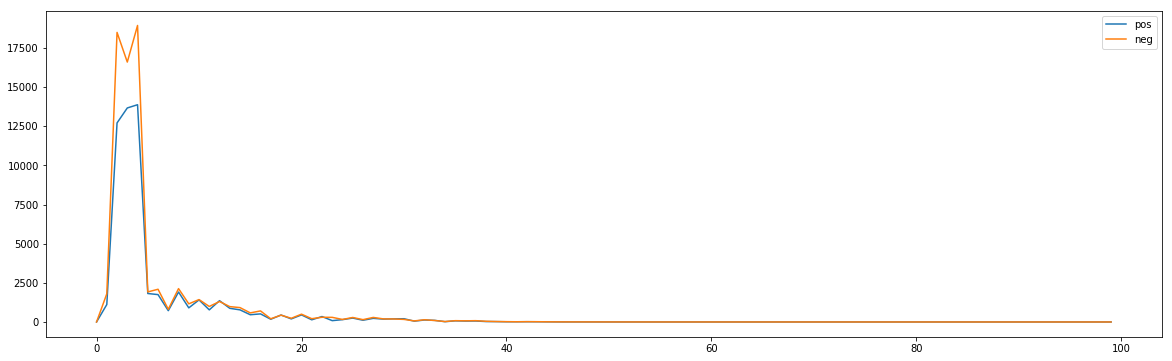

In [58]:
plt.figure(figsize=(20, 6))
plt.plot(np.arange(100), p_loss, label='pos')
plt.plot(np.arange(100), n_loss, label='neg')
plt.legend()
plt.show()